# Imports

In [ ]:
import torch
print(torch.__version__)

2.1.0+cu121


In [ ]:
!pip install torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


In [ ]:
!pip install torch_geometric

In [ ]:
# import required modules
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy
from torch_geometric.utils import degree

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

# Load Dataset

In [ ]:
# download the dataset
# https://grouplens.org/datasets/movielens/

url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
extract_zip(download_url(url, '.'), '.')
rating_path = './ml-100k/u.data'

Using existing file ml-100k.zip
Extracting ./ml-100k.zip


In [ ]:
# tổ chức lại dữ liệu đặt tên cho cột
columns_name = ['userId', 'movieId','rating', 'timestamp']
rating_df = pd.read_csv(rating_path, sep='\t', header=None, names=columns_name)
print(rating_df.head())

print(len(rating_df['movieId'].unique()))
print(len(rating_df['userId'].unique()))

rating_df.describe()


   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596
1682
943


,userId,movieId,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [ ]:
# Để tránh ID users và movies vượt quá unique count
# Encoder rồi fit_transform đưa các gtri về đoạn [0, unique_count-1] phù hợp với khuôn khổ ma trận
# range of [0, unique_count]
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [ ]:
print(rating_df.userId.max())
print(rating_df.movieId.max())

942
1681


In [ ]:
rating_df.rating.value_counts()

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

In [ ]:
# tạo cạnh giữa users và movies
def load_edge_csv(df,
                  src_index_col,
                  dst_index_col,
                  link_index_col,
                  rating_threshold):

    edge_index = None

    src = [user_id for user_id in  df['userId']]
    dst = [(movie_id) for movie_id in df['movieId']]

    #tạo tensor 1 chiều giá trị {0,1} với ngưỡng đánh giá
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold

    # Xây dựng định dạng COO cho edge_index từ rating (Coordinate)
    # tạo list chứa 2 list rỗng
    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
    return edge_index

In [ ]:
edge_index = load_edge_csv(
    rating_df,
    src_index_col='userId',
    dst_index_col='movieId',
    link_index_col='rating',
    rating_threshold=4,
)

print(f"{len(edge_index)} x {len(edge_index[0])}")

2 x 55375


In [ ]:
# Chuyển đổi sang tensor
# Chúng ta sd LongTensor hoặc SparseTensor vì cần cho method .propagate()
edge_index = torch.LongTensor(edge_index)
print(edge_index)
print(edge_index.size())

tensor([[ 297,  252,  285,  ...,  805,  675,  715],
        [ 473,  464, 1013,  ...,  420,  537,  203]])
torch.Size([2, 55375])


In [ ]:
# tổng users và movies
num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

In [ ]:
num_interactions = edge_index.shape[1]

# Chia cạnh đồ thị theo tỉ lệ train/val/test 80/10/10
all_indices = [i for i in range(num_interactions)]

train_indices, test_indice = train_test_split(all_indices,
                                               test_size=0.2,
                                               random_state=1)

val_indices, test_indices = train_test_split(test_indice,
                                             test_size=0.5,
                                             random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [ ]:
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies))
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())

num_users 943, num_movies 1682, num_interactions 55375
train_edge_index tensor([[412, 312, 591,  ...,  40, 377, 863],
        [299, 518, 432,  ...,  97, 175,  49]])
2625
torch.Size([942])
torch.Size([1416])


In [ ]:
# chuyển đổi từ ma trận tương tác thành ma trận kề
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index):
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1

    R_transpose = torch.transpose(R, 0, 1)
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo = adj_mat_coo.indices()
    return adj_mat_coo

In [ ]:
# chuyển đổi từ ma trận lề sang ma trận tương tác
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index):
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0],
                                           col=input_edge_index[1],
                                           sparse_sizes=((num_users + num_movies), (num_users + num_movies)))
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    return r_mat_edge_index

In [ ]:
# chuyển đổi ma trận tương tác sang ma trận kề ()
# số chiều thay đổi MxN => (M+N)x(M+N)
# convert interaction matrix to adjescency matrix
train_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index)
val_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index)
test_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index)

In [ ]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

tensor([[   0,    0,    0,  ..., 2606, 2606, 2616],
        [ 943,  945,  951,  ...,  869,  879,  839]])
torch.Size([2, 88600])
tensor([[   0,    0,    0,  ..., 2554, 2557, 2565],
        [ 948,  949,  970,  ...,  488,  806,  654]])
torch.Size([2, 11074])
tensor([[   0,    0,    0,  ..., 2534, 2562, 2581],
        [ 986,  999, 1000,  ...,  518,  549,  654]])
torch.Size([2, 11076])


In [ ]:
# lấy một minibatch ngẫu nhiên từ dữ liệu
def sample_mini_batch(batch_size, edge_index):
    edges = structured_negative_sampling(edge_index)

    edges = torch.stack(edges, dim=0)

    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)

    batch = edges[:, indices]

    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

In [ ]:
# defines LightGCN model
class LightGCN(MessagePassing):

    def __init__(self, num_users,
                 num_items,
                 embedding_dim=64, # độ dài vector nhúng mỗi nút
                 K=3,
                 add_self_loops=False):

        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops

        # nhúng lần đầu và khởi tạo trọng số cho layer 0
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0

        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: Tensor):
        # chuẩn hóa các giá trị dựa trên công thức dùng ma trận chuẩn hóa đối xứng
        edge_index_norm = gcn_norm(edge_index=edge_index,
                                   add_self_loops=self.add_self_loops)
        # ghép nối, kích thước (n_users + n_items) * 64
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0]
        emb_k = emb_0
        # thực hiện lan truyên qua K layer của mô hình
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)

        # tính trung bình để tạo ra embedding cuối cùng (siêu tham số 1/K+1 )
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items])

        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight
    # nhận thông điệp từ các nút láng giềng
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

layers = 4
model = LightGCN(num_users=num_users,
                 num_items=num_movies,
                 K=layers)

In [ ]:
def bpr_loss(users_emb_final,
             users_emb_0,
             pos_items_emb_final,
             pos_items_emb_0,
             neg_items_emb_final,
             neg_items_emb_0,
             lambda_val):

    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # hàm mất mát L2

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # dự đoán mẫu dương
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # dự đoán mẫu âm


    bpr_loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores))

    loss = bpr_loss + reg_loss

    return loss

In [ ]:
# sinh ra list pos item của user
def get_user_positive_items(edge_index):

    # key: user_id, val: item_id list
    user_pos_items = {}

    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()

        if user not in user_pos_items:
            user_pos_items[user] = []

        user_pos_items[user].append(item)

    return user_pos_items

In [ ]:
# tính recall@K và precision@K
def RecallPrecision_ATk(groundTruth, r, k):

    num_correct_pred = torch.sum(r, dim=-1)

    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])

    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred / k)
    return recall.item(), precision.item()

In [ ]:
# tính NDCG@K
def NDCGatK_r(groundTruth, r, k):

    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [ ]:
def get_metrics(model,
                input_edge_index,
                input_exclude_edge_indices,
                k):

    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)

    exclude_edge_indices = [convert_adj_mat_edge_index_to_r_mat_edge_index(exclude_edge_index) \
                                      for exclude_edge_index in input_exclude_edge_indices]

    r_mat_rating = torch.matmul(user_embedding, item_embedding.T)

    rating = r_mat_rating

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_positive_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        rating[exclude_users, exclude_items] = -(1 << 10)

    _, top_K_items = torch.topk(rating, k=k)

    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    r = []
    for user in users:
        user_true_relevant_item = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in user_true_relevant_item, top_K_items[user]))
        r.append(label)

    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [ ]:
def evaluation(model,
               edge_index,
               exclude_edge_indices,
               k,
               lambda_val
              ):

    # nhúng
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index)

    r_mat_edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index)

    edges = structured_negative_sampling(r_mat_edge_index, contains_neg_self_loops=False)

    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]

    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]

    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]

    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final,
                    users_emb_0,
                    pos_items_emb_final,
                    pos_items_emb_0,
                    neg_items_emb_final,
                    neg_items_emb_0,
                    lambda_val).item()


    recall, precision, ndcg = get_metrics(model,
                                          edge_index,
                                          exclude_edge_indices,
                                          k)

    return loss, recall, precision, ndcg

In [ ]:
ITERATIONS = 10000
EPOCHS = 10
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [ ]:
# setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

Using device cuda.


In [ ]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.1.0+cu121
CUDA available: True
CUDA version: 12.1


In [ ]:
def get_embs_for_bpr(model, input_edge_index):
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(input_edge_index)


    edge_index_to_use = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)

    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, edge_index_to_use)

    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)

    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    return users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0

In [ ]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward propagation
    users_emb_final, users_emb_0,  pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0 \
                = get_embs_for_bpr(model, train_edge_index)

    # loss computation
    train_loss = bpr_loss(users_emb_final,
                          users_emb_0,
                          pos_items_emb_final,
                          pos_items_emb_0,
                          neg_items_emb_final,
                          neg_items_emb_0,
                          LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # validation set
    if iter % ITERS_PER_EVAL == 0:
        model.eval()

        with torch.no_grad():
            val_loss, recall, precision, ndcg = evaluation(model,
                                                           val_edge_index,
                                                           [train_edge_index],
                                                           K,
                                                           LAMBDA
                                                          )

            print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")

            train_losses.append(train_loss.item())
            val_losses.append(val_loss)
            val_recall_at_ks.append(round(recall, 5))
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

[Iteration 0/10000] train_loss: -0.69197, val_loss: -0.68913, val_recall@20: 0.01048, val_precision@20: 0.00343, val_ndcg@20: 0.00629
[Iteration 200/10000] train_loss: -5.0584, val_loss: -4.78262, val_recall@20: 0.07297, val_precision@20: 0.02488, val_ndcg@20: 0.04607
[Iteration 400/10000] train_loss: -20.21819, val_loss: -18.97577, val_recall@20: 0.08515, val_precision@20: 0.02901, val_ndcg@20: 0.05251
[Iteration 600/10000] train_loss: -43.45503, val_loss: -39.56901, val_recall@20: 0.09525, val_precision@20: 0.0314, val_ndcg@20: 0.05706
[Iteration 800/10000] train_loss: -69.00095, val_loss: -66.2369, val_recall@20: 0.09834, val_precision@20: 0.03256, val_ndcg@20: 0.05931
[Iteration 1000/10000] train_loss: -100.54512, val_loss: -95.47134, val_recall@20: 0.10909, val_precision@20: 0.03535, val_ndcg@20: 0.06484
[Iteration 1200/10000] train_loss: -136.07549, val_loss: -126.07197, val_recall@20: 0.11632, val_precision@20: 0.03843, val_ndcg@20: 0.07
[Iteration 1400/10000] train_loss: -173.5

# Plot

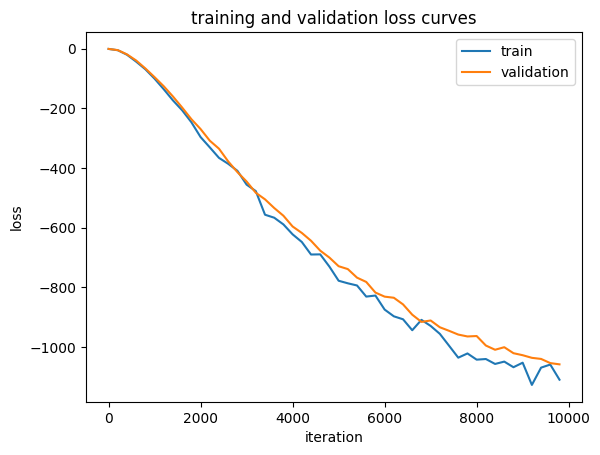

In [ ]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

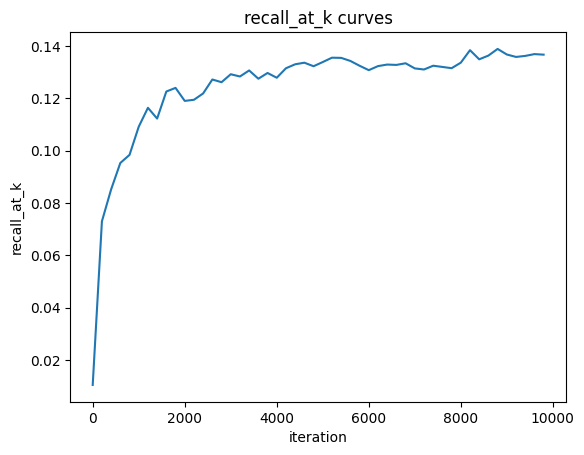

In [ ]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()

In [ ]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(model,
                                                               test_edge_index,
                                                               [train_edge_index, val_edge_index],
                                                               K,
                                                               LAMBDA
                                                              )

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -1061.35291, test_recall@20: 0.13031, test_precision@20: 0.04424, test_ndcg@20: 0.09132
